In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from scipy.linalg import orth
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.decomposition import PCA
from terminaltables import AsciiTable as Table
from tqdm.notebook import tqdm

In [2]:
def estimate_optimal_ncomponents(mat):
    pca = PCA()
    pca.fit(mat)
    opt = []
    total_var = 0
    nc = 0
    for var in pca.explained_variance_ratio_:
        total_var += var
        nc += 1
        if total_var >= 0.99:
            opt.append(nc)
            break
        elif total_var >= 0.95:
            opt.append(nc)
    return opt[0], opt[-1], len(pca.explained_variance_ratio_)

def pca_transform(mat):
    _, n, _ = estimate_optimal_ncomponents(mat)
    pca = PCA(n_components=n)
    return pca.fit_transform(mat)

def cosine_sim(u, v):
    return 1-cosine(u, v)

In [11]:
data = ['cifar']
lrs = [1e-1, 1e-2, 1e-3]
clfs = {
    'resnet18': [1024],
#     'fcn': [256, 1024],
}

files = {}
for d in data:
    for lr in lrs:
        for clf, batches in clfs.items():
            if clf == 'svm' and d=='cifar':
                lr *= 1e-3
            elif clf == 'svm':
                    lr *= 1e-2
            files[
                '../ckpts/{}_centralized/history/'
                'clf_{}_paradigm_sgd_lr_{}_decay_'
                '1e-05_batch_{}.pkl'.format(d, clf, lr, 1024)] = '{}/{}/{}'.format(d,clf,lr)

# Same Dataset Different Models

```python
grads->[
    epoch ->[
        minibatch->[
            layers->[
                tensors
            ]
        ]
    ]
]
```

[file:cifar/resnet18/0.1]


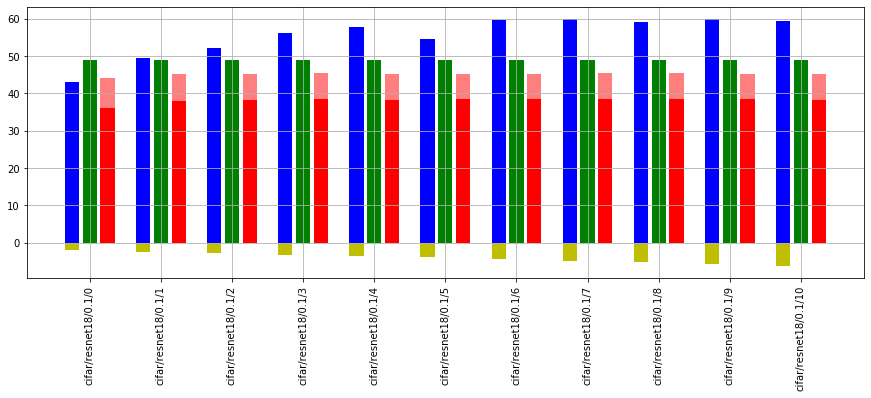

[file:cifar/resnet18/0.01]


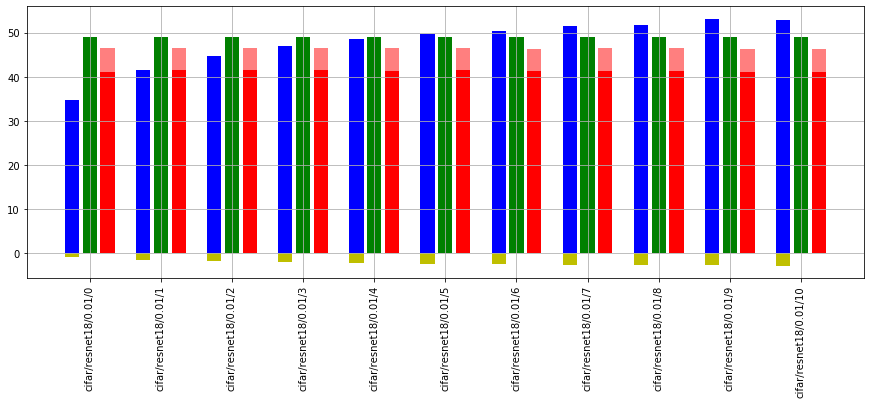

[file:cifar/resnet18/0.001]


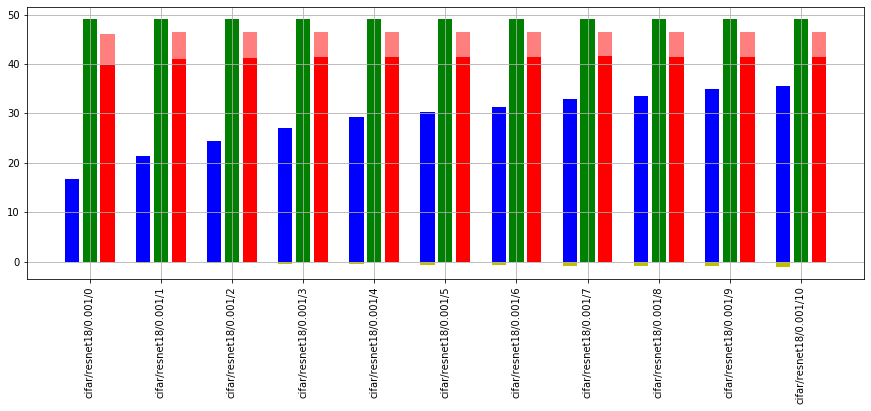

In [16]:
epochs = 11

nc_95 = defaultdict(list)
nc_90 = defaultdict(list)
f_hash = {}
for file, tick_name in tqdm(files.items(), leave=False):
    _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(111)
    tick_names = []
    ticks = []
    print('[file:{}]'.format(tick_name))
    table = [['expt', 'max(acc)', 'min(loss)', 'opt(0.95)', 'opt(0.99)']]
    for ep in tqdm(range(epochs), leave=False):
        ticks.append(ep)
        tick_names.append('{}/{}'.format(tick_name, ep))
        best_acc = np.max(acc_test)
        best_loss = np.min(loss_test)
        gradi = grads[ep]
        tot_opt_95 = 0
        tot_opt_99 = 0
        tot_epochs = 0
        for layer_num in range(len(gradi[0])):
            accum = []
            for b_num in range(len(gradi)):
                g = gradi[b_num][layer_num]
                shape = g.shape
                accum.append(g.reshape(1, -1).cpu().numpy())
            stack_g = np.vstack(accum)
            o_95, o_99, o_epochs = estimate_optimal_ncomponents(stack_g.T)
            tot_opt_95 += o_95
            tot_opt_99 += o_99
            tot_epochs += 1
        table.append([tick_name, 
                      '{:.4f}'.format(best_acc), 
                      '{:.4f}'.format(best_loss),
                      '{:.4f}'.format(tot_opt_95/tot_epochs), 
                      '{:.4f}'.format(tot_opt_99/tot_epochs)])
        nc_95[tick_name].append(tot_opt_99/tot_epochs)
        nc_90[tick_name].append(tot_opt_95/tot_epochs)
        
        idx = ep
        plt.bar(idx-0.25, acc_test[ep]*100, width = 0.2, color='b')
        plt.bar(idx-0.25, loss_test[ep], width=0.2, color='y')
        plt.bar(idx, len(gradi), width=0.2, color='g')
        plt.bar(idx+0.25, tot_opt_95/tot_epochs, width=0.2, color='r')
        plt.bar(idx+0.25, tot_opt_99/tot_epochs, width=0.2, color='r', alpha=0.5)
        idx += 1
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(tick_names, rotation='vertical')
    ax1.grid()
    plt.show()
    